In [202]:
import pandas as pd

# Read the CSV files
customers = pd.read_csv(r'd:\boothcamp_customergrowth\customers.csv')
transactions = pd.read_csv(r'd:\boothcamp_customergrowth\transactions.csv')

In [203]:
transactions["transaction_date"] = pd.to_datetime(
    transactions["transaction_date"]
)


In [204]:
transactions = transactions.sort_values(
    ["customer_id", "transaction_date"]
)

transactions["gap_days"] = (
    transactions
    .groupby("customer_id")["transaction_date"]
    .diff()
    .dt.days
)


In [205]:
gap_stats = (
    transactions
    .groupby("customer_id")["gap_days"]
    .median()
    .reset_index()
    .rename(columns={"gap_days": "median_gap"})
)

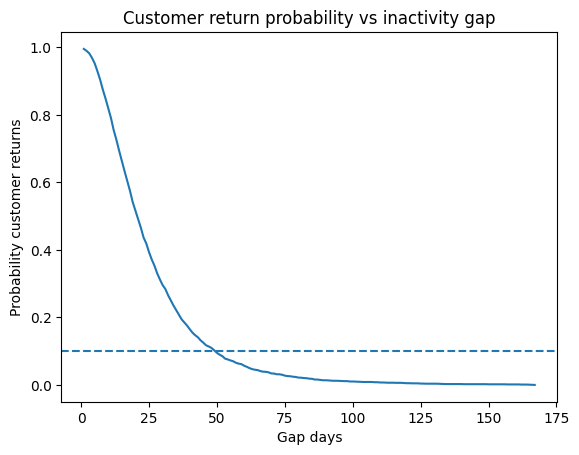

In [206]:
max_gap = (
    transactions
    .groupby("customer_id")["gap_days"]
    .max()
    .dropna()
)

thresholds = range(1, int(max_gap.max()) + 1)

retention = []
for t in thresholds:
    retention.append((max_gap > t).mean())

ret_df = pd.DataFrame({
    "gap_days": thresholds,
    "retention_rate": retention
})

import matplotlib.pyplot as plt

plt.figure()
plt.plot(ret_df["gap_days"], ret_df["retention_rate"])
plt.axhline(0.1, linestyle="--")  # 10% quay lại
plt.xlabel("Gap days")
plt.ylabel("Probability customer returns")
plt.title("Customer return probability vs inactivity gap")
plt.show()


In [207]:
customers["signup_date"] = pd.to_datetime(customers["signup_date"])
SNAPSHOT_DATE = transactions["transaction_date"].max()
SNAPSHOT_DATE


Timestamp('2025-12-31 00:00:00')

In [208]:
last_tx = (
    transactions
    .groupby("customer_id")["transaction_date"]
    .max()
    .reset_index()
    .rename(columns={"transaction_date": "last_transaction_date"})
)


In [209]:
churn_df = customers.merge(last_tx, on="customer_id", how="left")

churn_df["days_inactive"] = (
    SNAPSHOT_DATE - churn_df["last_transaction_date"]
).dt.days


In [210]:
CHURN_WINDOW = 75

churn_df["churn"] = (
    (churn_df["days_inactive"] >= CHURN_WINDOW) |
    (churn_df["last_transaction_date"].isna())
).astype(int)


# 1. Customer Value Foundations
Yêu cầu:
Tính RFM
Phân nhóm khách hàng:
- High-value / At-risk
- New / Loyal / Hibernating
Phân tích mối liên hệ:
- RFM vs churn
Mục tiêu: RFM có thể cung cấp phân tích ban đầu nhưng không đủ


In [211]:
snapshot_date = transactions["transaction_date"].max()

rfm = (
    transactions
    .groupby("customer_id")
    .agg({
        "transaction_date": lambda x: (snapshot_date - x.max()).days,
        "customer_id": "count",
        "amount": "sum"
    })
    .rename(columns={
        "transaction_date": "Recency",
        "customer_id": "Frequency",
        "amount": "Monetary"
    })
    .reset_index()
)


In [212]:
rfm["R_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

rfm["RFM_score"] = (
    rfm["R_score"].astype(int)*100 +
    rfm["F_score"].astype(int)*10 +
    rfm["M_score"].astype(int)
)
rfm.head()
def segment(row):
    if row["R_score"] >= 4 and row["F_score"] >= 4:
        return "High-value / Loyal"
    if row["R_score"] <= 2 and row["F_score"] >= 3:
        return "At-risk"
    if row["R_score"] >= 4 and row["F_score"] <= 2:
        return "New"
    if row["R_score"] <= 2 and row["F_score"] <= 2:
        return "Hibernating"
    return "Regular"

rfm["segment"] = rfm.apply(segment, axis=1)


In [213]:
rfm_churn = rfm.merge(
    churn_df[["customer_id", "churn"]],
    on="customer_id",
    how="left"
)


In [214]:
rfm_churn.groupby("segment")["churn"].mean().reset_index()

,segment,churn
0,At-risk,1.000000
1,Hibernating,1.000000
2,High-value / Loyal,0.000000
3,New,0.000000
4,Regular,0.158088


In [215]:
churn_by_segment = (
    rfm_churn
    .groupby("segment")
    .agg(
        total_customers=("customer_id", "count"),
        churned_customers=("churn", "sum"),
        churn_rate=("churn", "mean")
    )
    .reset_index()
)

churn_by_segment


,segment,total_customers,churned_customers,churn_rate
0,At-risk,485,485,1.000000
1,Hibernating,669,669,1.000000
2,High-value / Loyal,718,0,0.000000
3,New,204,0,0.000000
4,Regular,816,129,0.158088


Churn definition (60-day inactivity)

Một khách hàng được gán churn = 1 nếu:

Không có bất kỳ giao dịch nào trong khoảng
01/11/2025 – 31/12/2025

Ngược lại → churn = 0



Phân tích gap giao dịch trước đó cho thấy 75% gap < 60 ngày

60 ngày đủ dài để:

Loại bỏ hành vi mua không đều

Max date trong data: 2025-12-31

Prediction point (T): 2025-10-31 ⬅️ đứng tại đây

Churn window: T → T + 60 ngày

Tức là: 01/11/2025 – 31/12/2025

In [216]:
snapshot_date = pd.Timestamp("2025-12-31")
churn_window = 60

T = snapshot_date - pd.Timedelta(days=churn_window)
churn_end = snapshot_date


In [217]:
# Giao dịch trong churn window
future_tx = transactions[
    (transactions["transaction_date"] > T) &
    (transactions["transaction_date"] <= churn_end)
]

active_customers = future_tx["customer_id"].unique()


In [218]:
customers = transactions["customer_id"].unique()

churn_df = pd.DataFrame({"customer_id": customers})
churn_df["churn"] = ~churn_df["customer_id"].isin(active_customers)
churn_df["churn"] = churn_df["churn"].astype(int)


In [219]:
tx_before_T = transactions[transactions["transaction_date"] <= T]
rfm = (
    tx_before_T
    .groupby("customer_id")
    .agg({
        "transaction_date": lambda x: (T - x.max()).days,
        "customer_id": "count",
        "amount": "sum"
    })
    .rename(columns={
        "transaction_date": "Recency",
        "customer_id": "Frequency",
        "amount": "Monetary"
    })
    .reset_index()
)

In [220]:
recent_start = T - pd.Timedelta(days=60)

recent_tx = tx_before_T[
    tx_before_T["transaction_date"] > recent_start
]

past_tx = tx_before_T[
    tx_before_T["transaction_date"] <= recent_start
]

freq_recent = recent_tx.groupby("customer_id").size()
freq_past = past_tx.groupby("customer_id").size()

freq_trend = pd.concat([freq_recent, freq_past], axis=1)
freq_trend.columns = ["freq_recent", "freq_past"]
freq_trend = freq_trend.fillna(0)

freq_trend["freq_trend"] = freq_trend["freq_recent"] - freq_trend["freq_past"]


# 2. Churn Prediction as Classification
Churn = yes/no trong T tháng tới
Yêu cầu
Define churn label (30 / 60 / 90 ngày)
Feature engineering:
- RFM
- Frequency trend
Train model (Logistic / Tree)

In [221]:
data = (
    rfm
    .merge(freq_trend, on="customer_id", how="left")
    .merge(churn_df, on="customer_id")
)

data.fillna(0, inplace=True)

X = data.drop(columns=["customer_id", "churn"])
y = data["churn"]


In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [223]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train, y_train)

y_prob_lr = lr.predict_proba(X_test)[:, 1]


In [224]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

y_prob_dt = dt.predict_proba(X_test)[:, 1]


In [225]:
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_dt)
    ],
    "PR_AUC": [
        average_precision_score(y_test, y_prob_lr),
        average_precision_score(y_test, y_prob_dt)
    ]
})

results


,Model,AUC,PR_AUC
0,Logistic Regression,0.948401,0.962663
1,Decision Tree,0.939870,0.948339


In [226]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_prob_lr >= 0.5)
cm_lr


array([[324,  19],
       [ 68, 353]], dtype=int64)

In [227]:
cm_dt = confusion_matrix(y_test, y_prob_dt >= 0.5)
cm_dt


array([[322,  21],
       [ 69, 352]], dtype=int64)

In [228]:
coef_lr = (
    pd.Series(lr.coef_[0], index=X.columns)
    .sort_values(key=abs, ascending=False)
)

coef_lr


Recency        0.066209
freq_trend    -0.042468
freq_recent   -0.030546
Frequency     -0.018625
freq_past      0.011922
Monetary       0.000105
dtype: float64

In [229]:
feat_dt = (
    pd.Series(dt.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
)

feat_dt


Recency        0.970609
Frequency      0.022480
freq_trend     0.003180
freq_past      0.001756
Monetary       0.001530
freq_recent    0.000444
dtype: float64

# 3. Churn via BG-NBD
Yêu cầu
Fit BG-NBD
Estimate:
- P(alive)
- Expected #transactions
So sánh bắt buộc
Churn label vs P(alive)

In [230]:
from lifetimes.utils import summary_data_from_transaction_data

tx_bg = transactions[
    transactions["transaction_date"] <= pd.Timestamp("2025-10-31")
]

summary = summary_data_from_transaction_data(
    tx_bg,
    customer_id_col="customer_id",
    datetime_col="transaction_date",
    monetary_value_col=None,
    observation_period_end=pd.Timestamp("2025-10-31")
)

summary.head()


,frequency,recency,T
customer_id,,,
C00000,5.0,48.0,51.0
C00001,12.0,204.0,228.0
C00002,9.0,37.0,72.0
C00003,1.0,1.0,27.0
C00004,17.0,98.0,145.0


In [231]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(
    summary["frequency"],
    summary["recency"],
    summary["T"]
)


<lifetimes.BetaGeoFitter: fitted with 2531 subjects, a: 0.25, alpha: 12.73, b: 1.86, r: 1.53>

In [232]:
summary["p_alive"] = bgf.conditional_probability_alive(
    summary["frequency"],
    summary["recency"],
    summary["T"]
)


In [233]:
summary["exp_tx_60d"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    60,
    summary["frequency"],
    summary["recency"],
    summary["T"]
)


In [234]:
bg_churn = summary.merge(
    churn_df,  # churn label 60 ngày (đã làm ở phần 2)
    left_index=True,
    right_on="customer_id"
)


In [235]:
bg_churn.groupby("churn")["p_alive"].mean()


churn
0    0.905063
1    0.342467
Name: p_alive, dtype: float64

In [236]:
bg_churn.groupby("churn")["p_alive"].describe()


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,1130.0,0.905063,0.136469,4.247306e-03,0.891330,0.955481,0.981607,1.0
1,1401.0,0.342467,0.385442,4.494182e-15,0.004929,0.128276,0.732353,1.0


Churned customers có P(alive) thấp rõ rệt hơn so với non-churned customers. Điều này chứng tỏ mô hình BG/NBD có khả năng dự đoán tốt xác suất khách hàng còn hoạt động trong tương lai.

# 4. Churn with Survival Analysis
Time-to-churn modeling
Yêu cầu
Define duration & event
Fit CoxPH / Weibull
Predict:
- Survival curve
- Expected remaining lifetime


In [237]:
customers = pd.read_csv(r'd:\boothcamp_customergrowth\customers.csv')
transactions = pd.read_csv(r'd:\boothcamp_customergrowth\transactions.csv')

In [238]:
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
customers["signup_date"] = pd.to_datetime(customers["signup_date"])

last_tx = (
    transactions
    .groupby("customer_id")["transaction_date"]
    .max()
    .reset_index()
)

In [239]:
end_date = pd.Timestamp("2025-12-31")
churn_window = pd.Timedelta(days=60)

df_surv = (
    customers
    .merge(last_tx, on="customer_id", how="left")
)

df_surv["event"] = (
    df_surv["transaction_date"] + churn_window < end_date
).astype(int)


In [240]:
import numpy as np
df_surv["event_date"] = (
    df_surv["transaction_date"] + churn_window
).where(
    df_surv["event"] == 1,
    end_date
)


df_surv["duration"] = (
    df_surv["event_date"] - df_surv["signup_date"]
).dt.days


In [241]:
surv_data = (
    df_surv
    .merge(rfm, on="customer_id", how="left")
    .merge(freq_trend, on="customer_id", how="left")
)

surv_data.fillna(0, inplace=True)


Fit CoxPH

In [242]:
surv_data.columns = surv_data.columns.str.lower()


In [243]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(
    surv_data[["duration","event",
        "recency",
        "frequency",
        "monetary"
    ]],
    duration_col="duration",
    event_col="event"
)


<lifelines.CoxPHFitter: fitted with 3000 total observations, 1602 right-censored observations>

In [244]:
cph.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
recency,0.015076,1.015190,0.000417,0.014258,0.015894,1.014361,1.016021,0.0,36.134597,6.494545e-286,947.372207
frequency,-0.030697,0.969769,0.003950,-0.038438,-0.022956,0.962291,0.977306,0.0,-7.772076,7.720987e-15,46.880136
monetary,-0.000076,0.999924,0.000055,-0.000183,0.000031,0.999817,1.000031,0.0,-1.392546,1.637573e-01,2.610369


coef > 0 → tăng hazard → churn sớm hơn

coef < 0 → giảm hazard → sống lâu hơn

In [245]:
from lifelines import WeibullAFTFitter

weibull = WeibullAFTFitter()
weibull.fit(
    surv_data[["duration","event",
        "recency",
        "frequency",
        "monetary"
    ]],
    duration_col="duration",
    event_col="event"
)


<lifelines.WeibullAFTFitter: fitted with 3000 total observations, 1602 right-censored observations>

In [246]:
expected_lifetime = cph.predict_median(surv_data)
expected_lifetime_weibull = weibull.predict_expectation(surv_data)

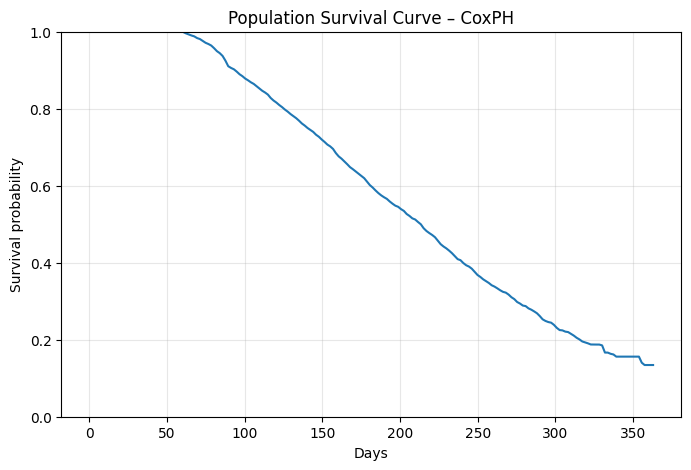

In [247]:
timeline = np.linspace(
    0,
    surv_data["duration"].max(),
    200
)

surv_all = cph.predict_survival_function(
    surv_data[["duration","event",
        "recency",
        "frequency",
        "monetary"
    ]],
    times=timeline
)

population_survival = surv_all.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(timeline, population_survival)
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Population Survival Curve – CoxPH")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()



In [248]:
# lấy đúng khách C00000
sample = surv_data.loc[
    surv_data["customer_id"] == "C00000",
    ["duration","event","recency","frequency","monetary"]
]

In [249]:
surv_cox = cph.predict_survival_function(
    sample,
    times=timeline
)
surv_weibull = weibull.predict_survival_function(
    sample,
    times=timeline
)



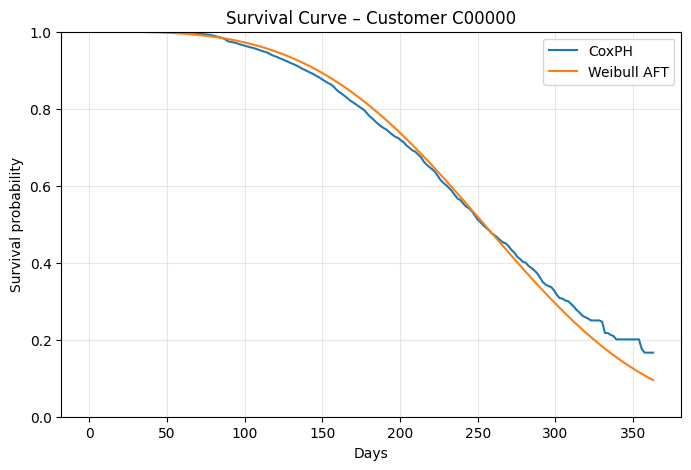

In [250]:
plt.figure(figsize=(8, 5))

plt.plot(
    timeline,
    surv_cox.iloc[:, 0],
    label="CoxPH"
)

plt.plot(
    timeline,
    surv_weibull.iloc[:, 0],
    label="Weibull AFT"
)

plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Survival Curve – Customer C00000")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 5. CLV Modeling
Future value estimation based on customer lifetime
Approach 1 – BG-NBD + Gamma–Gamma
Yêu cầu
Fit BG-NBD
Predict:
- Expected number of future transactions
- Probability customer is alive
Fit Gamma–Gamma
Compute:
- Expected monetary value
- CLV over time horizon T

In [251]:
end_date = pd.Timestamp("2025-12-31")
clv_data = summary_data_from_transaction_data(
    transactions,
    customer_id_col="customer_id",
    datetime_col="transaction_date",
    monetary_value_col="amount",
    observation_period_end=end_date
)


In [252]:
bgf = BetaGeoFitter(penalizer_coef=0.01)

bgf.fit(
    clv_data["frequency"],
    clv_data["recency"],
    clv_data["T"]
)


<lifetimes.BetaGeoFitter: fitted with 2892 subjects, a: 0.28, alpha: 9.62, b: 2.01, r: 1.35>

In [253]:
T_future = 60

clv_data["exp_txn_60d"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    T_future,
    clv_data["frequency"],
    clv_data["recency"],
    clv_data["T"]
)


In [254]:
clv_data["p_alive"] = bgf.conditional_probability_alive(
    clv_data["frequency"],
    clv_data["recency"],
    clv_data["T"]
)


In [255]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.01)

mask = clv_data["frequency"] > 0

ggf.fit(
    clv_data.loc[mask, "frequency"],
    clv_data.loc[mask, "monetary_value"]
)


<lifetimes.GammaGammaFitter: fitted with 2755 subjects, p: 3.86, q: 0.69, v: 3.83>

In [256]:
clv_data["exp_monetary"] = ggf.conditional_expected_average_profit(
    clv_data["frequency"],
    clv_data["monetary_value"]
)
clv_data["clv_60d"] = (
    clv_data["exp_txn_60d"] *
    clv_data["exp_monetary"]
)



In [257]:
import joblib

# Save logistic regression model
joblib.dump(lr, r'd:\boothcamp_customergrowth\logistic_regression_model.pkl')
print("Model saved to: d:\\boothcamp_customergrowth\\logistic_regression_model.pkl")

Model saved to: d:\boothcamp_customergrowth\logistic_regression_model.pkl


In [258]:
# Prepare features for prediction on snapshot date 2025-12-31
snapshot_date = pd.Timestamp("2025-12-31")

# Get last transaction before snapshot date
last_tx_snapshot = (
    transactions[transactions["transaction_date"] <= snapshot_date]
    .groupby("customer_id")["transaction_date"]
    .max()
    .reset_index()
)

# Calculate RFM at snapshot date
rfm_snapshot = (
    transactions[transactions["transaction_date"] <= snapshot_date]
    .groupby("customer_id")
    .agg({
        "transaction_date": lambda x: (snapshot_date - x.max()).days,
        "customer_id": "count",
        "amount": "sum"
    })
    .rename(columns={
        "transaction_date": "Recency",
        "customer_id": "Frequency",
        "amount": "Monetary"
    })
    .reset_index()
)


In [259]:
# Calculate frequency trend at snapshot date
recent_start = snapshot_date - pd.Timedelta(days=60)
tx_snapshot = transactions[transactions["transaction_date"] <= snapshot_date]

recent_tx_snap = tx_snapshot[
    tx_snapshot["transaction_date"] > recent_start
]

past_tx_snap = tx_snapshot[
    tx_snapshot["transaction_date"] <= recent_start
]

freq_recent_snap = recent_tx_snap.groupby("customer_id").size()
freq_past_snap = past_tx_snap.groupby("customer_id").size()

freq_trend_snap = pd.concat([freq_recent_snap, freq_past_snap], axis=1)
freq_trend_snap.columns = ["freq_recent", "freq_past"]
freq_trend_snap = freq_trend_snap.fillna(0)
freq_trend_snap["freq_trend"] = freq_trend_snap["freq_recent"] - freq_trend_snap["freq_past"]
freq_trend_snap = freq_trend_snap.reset_index()


In [260]:
# Combine all features for prediction
X_pred = (
    rfm_snapshot
    .merge(freq_trend_snap, on="customer_id", how="left")
    .fillna(0)
)

# Ensure columns are in the same order as training
X_pred = X_pred[X.columns]

print(f"Shape of prediction data: {X_pred.shape}")
print(f"Features: {X_pred.columns.tolist()}")
print(f"\nFirst few rows:")
print(X_pred.head())


Shape of prediction data: (2892, 6)
Features: ['Recency', 'Frequency', 'Monetary', 'freq_recent', 'freq_past', 'freq_trend']

First few rows:
   Recency  Frequency  Monetary  freq_recent  freq_past  freq_trend
0        0         12   1222.85          6.0        6.0         0.0
1       11         19   1228.46          5.0       14.0        -9.0
2       96         11    910.64          0.0       11.0       -11.0
3       43          4    114.71          2.0        2.0         0.0
4      108         19   2018.94          0.0       19.0       -19.0


In [261]:
# Make predictions using the saved logistic regression model
y_pred_proba = lr.predict_proba(X_pred)[:, 1]
y_pred_class = lr.predict(X_pred)

predictions_df = rfm_snapshot[["customer_id"]].copy()
predictions_df["churn_probability"] = y_pred_proba
predictions_df["churn_prediction"] = y_pred_class
predictions_df = predictions_df.sort_values("churn_probability", ascending=False)

print(f"Churn predictions for snapshot date: {snapshot_date.date()}")
print(f"\nTop 20 at-risk customers (highest churn probability):")
print(predictions_df.head(20))

print(f"\n\nSummary Statistics:")
print(f"Total customers: {len(predictions_df)}")
print(f"Predicted churned: {predictions_df['churn_prediction'].sum()}")
print(f"Churn rate: {predictions_df['churn_prediction'].mean():.2%}")


Churn predictions for snapshot date: 2025-12-31

Top 20 at-risk customers (highest churn probability):
     customer_id  churn_probability  churn_prediction
696       C00725                1.0                 1
522       C00545                1.0                 1
199       C00208                1.0                 1
1772      C01838                1.0                 1
94        C00100                1.0                 1
710       C00739                1.0                 1
700       C00729                1.0                 1
1290      C01341                1.0                 1
1719      C01784                1.0                 1
967       C01004                1.0                 1
963       C01000                1.0                 1
874       C00910                1.0                 1
1829      C01896                1.0                 1
834       C00867                1.0                 1
2818      C02922                1.0                 1
1070      C01110                1

Nếu ngân sách retention chỉ đủ giữ 20% customer base, thì chọn 20% này theo cách nào?
3 chiến lược cần so sánh
    1. High churn probability (classification)
    2. Low P(alive) (BG-NBD)
    3. High CLV × High churn risk (Survival-based)

In [262]:
clv_data.columns

Index(['frequency', 'recency', 'T', 'monetary_value', 'exp_txn_60d', 'p_alive',
       'exp_monetary', 'clv_60d'],
      dtype='object')

In [263]:
df = clv_data.merge(
    predictions_df[["customer_id", "churn_probability"]],
    on="customer_id",
    how="left"
)


In [264]:
df["churn_risk_cls"] = df["churn_probability"]
df["churn_risk_bgnbd"] = 1 - df["p_alive"]


In [265]:
df["rank_churn_cls"] = df["churn_risk_cls"].rank(
    pct=True,
    ascending=False
)

target_cls = df[df["rank_churn_cls"] <= 0.20]


In [266]:
df["rank_alive"] = df["p_alive"].rank(pct=True)

target_bgnbd = df[df["rank_alive"] <= 0.20]


In [267]:
from sklearn.preprocessing import StandardScaler

features = ["recency", "frequency", "monetary"]

scaler = StandardScaler()

surv_data_scaled = surv_data.copy()
surv_data_scaled[features] = scaler.fit_transform(
    surv_data[features]
)
cph = CoxPHFitter(penalizer=0.1)

cph.fit(
    surv_data_scaled[
        ["duration", "event", "recency", "frequency", "monetary"]
    ],
    duration_col="duration",
    event_col="event"
)
X = surv_data_scaled[["recency", "frequency", "monetary"]]

surv_funcs = cph.predict_survival_function(X)



In [268]:
t = 60

survival_60d = cph.predict_survival_function(
    X,
    times=[t]
).iloc[0].values

surv_data["survival_60d"] = survival_60d
surv_data["churn_risk_surv"] = 1 - surv_data["survival_60d"]


In [269]:
times = surv_funcs.index.values

expected_lifetime = np.trapz(
    surv_funcs.values,
    times,
    axis=0
)

surv_data["expected_lifetime"] = expected_lifetime

In [270]:
df = df.merge(
    surv_data[
        [
            "customer_id",
            "survival_60d",
            "churn_risk_surv",
            "expected_lifetime"
        ]
    ],
    on="customer_id",
    how="left"
)


In [271]:
df["clv_surv"] = (
    df["exp_txn_60d"]
    * df["exp_monetary"]
    * df["survival_60d"]
)


In [272]:
df["retention_score_surv"] = (
    df["clv_surv"] * df["churn_risk_surv"]
)
df["rank_surv"] = df["retention_score_surv"].rank(
    pct=True,
    ascending=False
)

target_survival = df[df["rank_surv"] <= 0.20]


In [273]:
compare = pd.DataFrame({
    "strategy": [
        "High churn (classification)",
        "Low P(alive) (BG-NBD)",
        "High CLV × churn (Survival)"
    ],
    "total_clv": [
        target_cls["clv_60d"].sum(),
        target_bgnbd["clv_60d"].sum(),
        target_survival["clv_surv"].sum()
    ]
})
print("Comparison of Targeting Strategies Based on CLV:")

Comparison of Targeting Strategies Based on CLV:


In [275]:
compare

,strategy,total_clv
0,High churn (classification),-529.773549
1,Low P(alive) (BG-NBD),56.734188
2,High CLV × churn (Survival),0.000000


=> lấy theo bgnbd vì đem lại clv cao nhất
